# Estimate effective population size via hapROH segments

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import socket as socket
import os as os
import sys as sys
import h5py
import matplotlib.cm as cm
import itertools as it
import multiprocessing as mp

socket_name = socket.gethostname()
print(socket_name)
    
if socket_name.startswith("bionc"):
    print("Leipzig Cluster detected!")
    path = "/mnt/archgen/users/hringbauer/git/ibd_gurgy/"
    #sys.path.append() 
    
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']

#from hapsburg.figures.plot_ibdx import new_column, give_sub_df
#from run import hapBLOCK_chroms

bionc21
Leipzig Cluster detected!
/mnt/archgen/users/hringbauer/git/ibd_gurgy
CPU Count: 40


# Load ROH

In [76]:
df = pd.read_csv("./output/roh/combined_roh05.csv", sep='\t') # The new IBD

# Rename IIDs to remove ugly library name
iids = df["iid"].str.split(".").values
iids = [i[0] for i in iids]
df["iid"] = iids
#df["age_iid"] = df["age"].values
df["age"] = 6000

print(f"Successfully loaded {len(df)} IIDs")

### Load Meta Data with Family Info
df1 = pd.read_csv("./data/tree/family_all.v2.tsv", sep="\t")
df1["iid"] = df1["t"]
df1["fam"] = [f"Fam. {i}" if i in ("a","b") else "Other" for i in df1["fam"]]
df2 = pd.merge(df, df1[["iid", "fam"]], on="iid", how="left")

print(f"Combined with Fam. Info for {len(df2)} ")

idx = df2["fam"].isnull()
print(f"Missing Fam. Data for {np.sum(idx)} iids")

Successfully loaded 86 IIDs
Combined with Fam. Info for 86 
Missing Fam. Data for 0 iids


In [33]:
df2["fam"].value_counts()

Fam. a    58
Other     18
Fam. b    10
Name: fam, dtype: int64

In [42]:
np.sum(df2["max_roh"]>8)

41

# Optional Excursion: Plot summary statistics ROH

In [77]:
from hapsburg.figures.plot_bars import plot_legend_only, plot_panel_row, prepare_dfs_plot

Saved figure to ./figs/roh/roh_bar.pdf


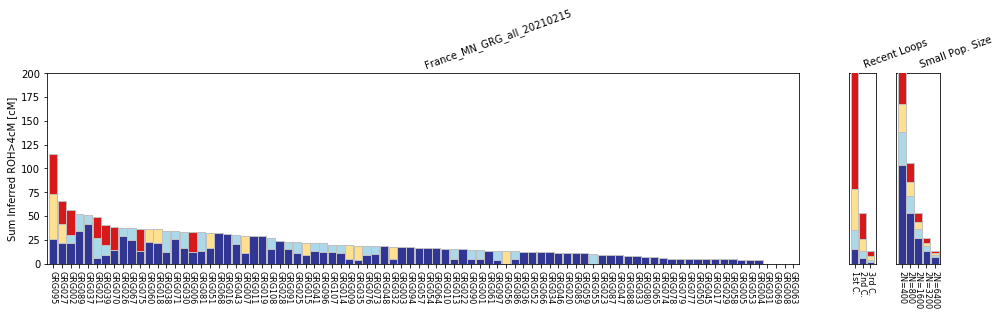

In [78]:
plot_dfs, cols = prepare_dfs_plot(df, cms=[4, 8, 12, 20], col_group='clst')

# ./figures_test/freilich20_bars.pdf
plot_panel_row(plot_dfs, wspace=0.1, r_title=20, leg_pos=-2, 
               ylim=[0,200], figsize=(16,3.5), savepath="./figs/roh/roh_bar.pdf")

### Calculate Statistic for Paper

In [82]:
idx = df["max_roh"]>4
print(f"{np.sum(idx)}/{len(idx)}")

idx = df["max_roh"]>8
print(f"{np.sum(idx)}/{len(idx)}")

82/86
41/86


Saved figure to ./figs/roh/fam_roh_bar.pdf


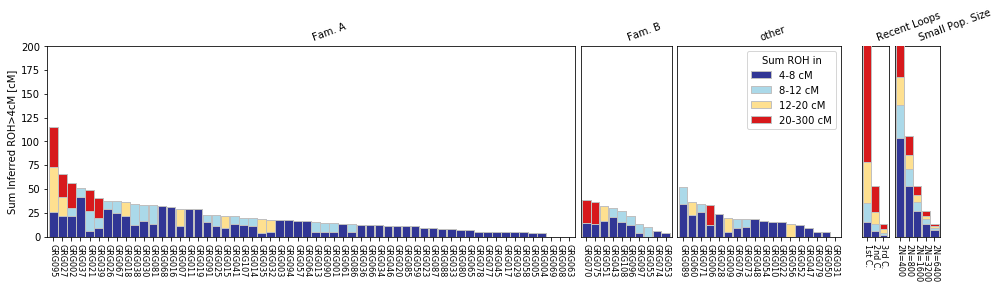

In [37]:
plot_dfs, cols = prepare_dfs_plot(df2, cms=[4, 8, 12, 20], col_group='fam')
titles = ["Fam. A", "Fam. B", "other"]
plot_panel_row(plot_dfs, wspace=0.04, r_title=20, leg_pos=-1, 
               ylim=[0,200], figsize=(16,3.5), savepath="./figs/roh/fam_roh_bar.pdf", titles = titles)

# 1) Estimate Ne from ROH

# Estimate Ne

In [22]:
from hapsburg.PackagesSupport.fit_ne import MLE_ROH_Ne, load_roh_vec

In [23]:
%%time
df = pd.read_csv("./output/roh/combined_roh05.csv", sep='\t') # The new IBD
iids = df["iid"].values

### Do possible filtering for IIds here [not implemented]

roh_vec = load_roh_vec(iids=iids, base_path = "./output/roh/", suffix="_roh_full.csv")
print(f"Loaded indivdiual ROH for {len(roh_vec)} Indivdiuals")

Loaded indivdiual ROH for 86 Indivdiuals
CPU times: user 461 ms, sys: 0 ns, total: 461 ms
Wall time: 6.53 s


In [24]:
%%time
output = True
min_len = 4 # Min ROH length in cM to fit
max_len = 20 # Max ROH length in cM to fit

mle = MLE_ROH_Ne(start_params=1000, endog=roh_vec,
                 min_len=min_len, max_len=max_len,
                 chr_lgts=[],      # lengths of Chromosomes to fit (in cM). If len 0, use default for 1240K
                 error_model=False, output=False)
fit = mle.fit_ll_profile()
#summary = fit.summary()
mle.summary/2  # to get estimates in terms of Ne

/home/harald_ringbauer/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


CPU times: user 3.58 s, sys: 0 ns, total: 3.58 s
Wall time: 3.73 s


,coef,std err,0.025,0.975,n
0,1834.571189,NaN,1631.111005,2077.727667,43.0


### Alternative Model

In [36]:
%%time
output = True
min_len = 4 # Min ROH length in cM to fit
max_len = 20 # Max ROH length in cM to fit

mle = MLE_ROH_Ne(start_params=1000, endog=roh_vec,
                 min_len=4, max_len=20,
                 chr_lgts=[],      # lengths of Chromosomes to fit (in cM). If len 0, use default for 1240K
                 error_model=False, output=False)
fit = mle.fit()
#summary = fit.summary()
mle.summary/2  # to get estimates in terms of Ne

/home/harald_ringbauer/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


Optimization terminated successfully.
         Current function value: 11.898674
         Iterations: 29
         Function evaluations: 59


/home/harald_ringbauer/.local/lib/python3.8/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")
/home/harald_ringbauer/.local/lib/python3.8/site-packages/statsmodels/base/model.py:2696: UserWarning: df_resid differs from nobs - nparams
  warnings.warn("df_resid differs from nobs - nparams")


CPU times: user 409 ms, sys: 54.8 ms, total: 464 ms
Wall time: 1.02 s


,coef,std err,0.025,0.975
const,1835.26725,117.59,1604.7955,2065.739


### Fit for different length classes

In [45]:
%%time

boarders = [[4,8],[8,12],[12,20],[20,30],[4,20]]

dfts = []

for i,b in enumerate(boarders):     
    mle = MLE_ROH_Ne(start_params=1000, endog=roh_vec,
                     min_len=b[0], max_len=b[1],
                     chr_lgts=[],      # lengths of Chromosomes to fit (in cM). If len 0, use default for 1240K
                     error_model=False, output=False)
    
    fit = mle.fit_ll_profile()
    #summary = fit.summary()
    dft = mle.summary/2  # to get estimates in terms of Ne
    dft["roh_l"] = "-".join(np.array(b).astype("str"))
    dfts.append(dft)

df_res = pd.concat(dfts)
df_res

CPU times: user 15.3 s, sys: 0 ns, total: 15.3 s
Wall time: 15.3 s


,coef,std err,0.025,0.975,n,roh_l
0,1747.887787,NaN,1532.697648,2007.121245,43.0,4-8
0,2049.191836,NaN,1480.612719,2956.254207,43.0,8-12
0,2592.296772,NaN,1575.681742,4698.324157,43.0,12-20
0,1170.413638,NaN,650.255626,2435.890109,43.0,20-30
0,1834.571189,NaN,1631.111005,2077.727667,43.0,4-20


In [46]:
df_res

,coef,std err,0.025,0.975,n,roh_l
0,1747.887787,NaN,1532.697648,2007.121245,43.0,4-8
0,2049.191836,NaN,1480.612719,2956.254207,43.0,8-12
0,2592.296772,NaN,1575.681742,4698.324157,43.0,12-20
0,1170.413638,NaN,650.255626,2435.890109,43.0,20-30
0,1834.571189,NaN,1631.111005,2077.727667,43.0,4-20


# Area 51

In [32]:
### Check all indivdiuals with long ROH
df[df["sum_roh>20"]>20]

,max_roh,iid,pop,sum_roh>4,n_roh>4,sum_roh>8,n_roh>8,sum_roh>12,n_roh>12,sum_roh>20,n_roh>20,sex,clst,n_cov_snps
0,21.540296,GRG095.A0101,France_MN_GRG_all_20210215,115.212005,10,89.815491,5,89.815491,5,42.202998,2,M,France_MN_GRG_all_20210215,704907
1,25.133502,GRG027.A0102,France_MN_GRG_all_20210215,66.184599,6,44.072401,2,44.072401,2,25.133502,1,M,France_MN_GRG_all_20210215,773741
2,25.536799,GRG002.A0101,France_MN_GRG_all_20210215,56.064188,6,34.605502,2,25.536799,1,25.536799,1,M,France_MN_GRG_all_20210215,744597
5,21.709800,GRG021.A0102,France_MN_GRG_all_20210215,48.615407,4,42.663204,3,21.709800,1,21.709800,1,M,France_MN_GRG_all_20210215,721756
6,21.501600,GRG039.A0101,France_MN_GRG_all_20210215,40.508492,4,31.623292,2,21.501600,1,21.501600,1,F,France_MN_GRG_all_20210215,641602
7,24.187696,GRG070.A0101,France_MN_GRG_all_20210215,38.722896,3,24.187696,1,24.187696,1,24.187696,1,F,France_MN_GRG_all_20210215,606055
10,23.203397,GRG075.A0101,France_MN_GRG_all_20210215,36.484695,3,23.203397,1,23.203397,1,23.203397,1,F,France_MN_GRG_all_20210215,712825
16,20.806694,GRG006.B0101,France_MN_GRG_all_20210215,33.096596,3,20.806694,1,20.806694,1,20.806694,1,F,France_MN_GRG_all_20210215,623347
